# Model Statistical Analysis and Comparison

### Introduction

This document outlines the comparison of the performance of our models using a Wilcoxon Hypothesis Test. The primary objective is to determine if the models are statistically different in terms of their performance on a given metric and to choose the one with the best performance.

### Libraries and Data Loading

The process begins with the importation of relevant libraries and the loading of our dataset.

In [12]:
from kfold_and_metrics import *

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
tf.keras.backend.clear_session()

import pandas as pd
import scipy.stats as ss

In [13]:
df = pd.read_csv("final.csv")
df = df.drop(columns=["id"])
print(df.shape)
df.head()

(2948, 1132)


,patient_id,diagnostics_Image-original_Mean,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-original_VolumeNum,diagnostics_Image-interpolated_Mean,diagnostics_Image-interpolated_Minimum,diagnostics_Image-interpolated_Maximum,diagnostics_Mask-interpolated_VoxelNum,diagnostics_Mask-interpolated_VolumeNum,diagnostics_Mask-interpolated_Maximum,...,diagnostics_Mask-interpolated_BoundingBox_2,diagnostics_Mask-interpolated_BoundingBox_3,diagnostics_Mask-interpolated_BoundingBox_4,diagnostics_Mask-interpolated_BoundingBox_5,diagnostics_Mask-interpolated_CenterOfMassIndex_0,diagnostics_Mask-interpolated_CenterOfMassIndex_1,diagnostics_Mask-interpolated_CenterOfMassIndex_2,diagnostics_Mask-interpolated_CenterOfMass_0,diagnostics_Mask-interpolated_CenterOfMass_1,diagnostics_Mask-interpolated_CenterOfMass_2
0,LIDC-IDRI-0001,-826.943929,5905,1,-417.494203,-990.291016,1038.270874,909,2,237.087921,...,0.0,13.0,11.0,10.0,17.041265,16.108666,4.184319,128.652843,34.787644,-229.881362
1,LIDC-IDRI-0001,-826.943929,4613,1,-405.581777,-982.456726,949.768005,699,1,221.953705,...,0.0,13.0,11.0,10.0,17.041265,16.108666,4.184319,128.652843,34.787644,-229.881362
2,LIDC-IDRI-0001,-826.943929,4955,1,-410.236759,-990.291016,1038.270874,772,1,237.087921,...,0.0,13.0,11.0,10.0,17.041265,16.108666,4.184319,128.652843,34.787644,-229.881362
3,LIDC-IDRI-0001,-826.943929,5498,1,-416.576321,-990.291016,1038.270874,841,2,237.087921,...,0.0,13.0,11.0,10.0,17.041265,16.108666,4.184319,128.652843,34.787644,-229.881362
4,LIDC-IDRI-0002,-826.943929,10351,1,-546.359139,-1007.657349,1020.174988,749,1,160.687653,...,0.0,13.0,11.0,10.0,17.041265,16.108666,4.184319,128.652843,34.787644,-229.881362


### Hyperparameters

Hyperparameters play a crucial role in model performance. Here, we define the hyperparameters for each of our models based on the results of the hyperparameter tuning process.

In [14]:
rf_params = {
    'n_estimators': 25,
	'max_depth': 25,
	'min_samples_leaf': 5,
	'criterion': "log_loss"
}

xgb_params = {
    'n_estimators': 25,
	'max_depth': 5,
	'min_child_weight': 15
}

nn_params = {
    'hidden_layer_nodes': 60,
	'hidden_layer_activation': "relu",
	'learning_rate': 0.01
}

### Model Compilation

Models are compiled using the specified hyperparameters. We have three models in consideration: Random Forest, XGBoost, and a Neural Network (Multi Layer Perceptron).

In [15]:
rf = RandomForestClassifier(**rf_params)
xgb = XGBClassifier(**xgb_params)

nn = tf.keras.models.Sequential([
    tf.keras.layers.Input((100,), name="input"),
    tf.keras.layers.Dense(nn_params['hidden_layer_nodes'], activation=nn_params['hidden_layer_activation']),
    tf.keras.layers.Dense(2,activation='softmax')
])

nn.compile(
    optimizer=tf.keras.optimizers.SGD(nn_params['learning_rate']), 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

### Confusion Matrices

A preliminary assessment of the models' performances is conducted using confusion matrices. This provides an initial insight into how the models perform.

#### Random Forest

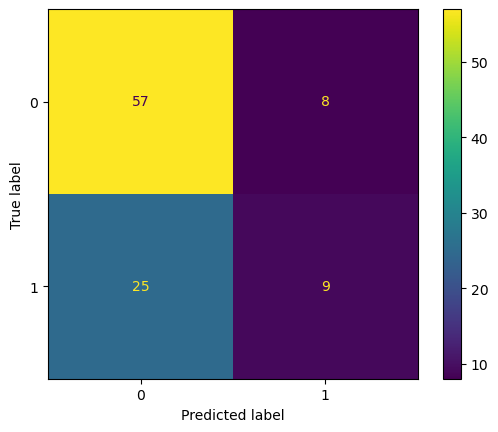

In [16]:
rf_scores = k_fold_cv(model=rf, df=df, pca_components=100, show_confusion_matrix=True)

#### XGBoost

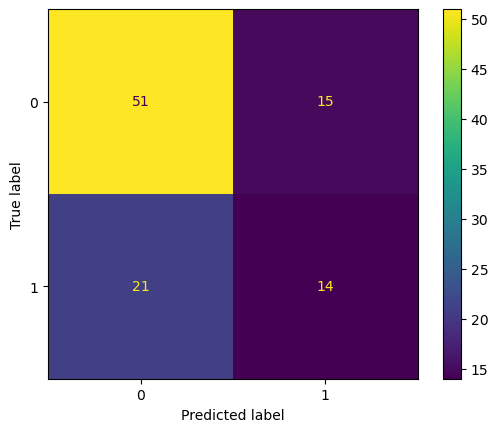

In [17]:
xgb_scores = k_fold_cv(model=xgb, df=df, pca_components=100, show_confusion_matrix=True)

#### Neural Network

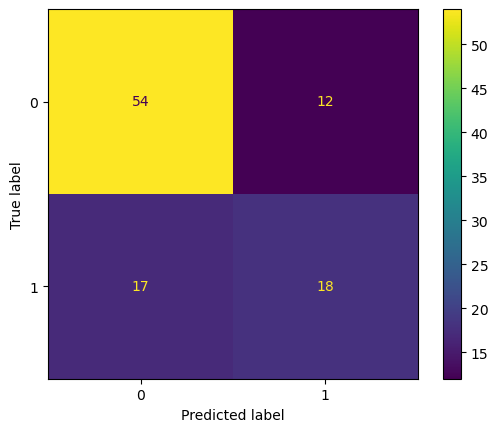

In [18]:
nn_scores = k_fold_cv_keras(compiled_model=nn, df=df, pca_components=100, show_confusion_matrix=True)

### Main Metrics

Additionally, key performance metrics, including F1 Score, Accuracy, and AUC, are computed to evaluate the models' performance.

#### Random Forest

In [19]:
rf_metrics = mean_std_results_k_fold_CV(rf_scores)
rf_metrics

,metric,mean,std
0,f1_score,0.346234,0.057891
1,accuracy_score,0.663929,0.041010
2,roc_auc_score,0.569620,0.028053


#### XGBoost

In [20]:
xgb_metrics = mean_std_results_k_fold_CV(xgb_scores)
xgb_metrics

,metric,mean,std
0,f1_score,0.429173,0.068625
1,accuracy_score,0.645935,0.034490
2,roc_auc_score,0.587457,0.032283


#### Neural Network

In [21]:
nn_metrics = mean_std_results_k_fold_CV(nn_scores)
nn_metrics

,metric,mean,std
0,f1_score,0.546275,0.103984
1,accuracy_score,0.718118,0.056883
2,roc_auc_score,0.661488,0.057819


### Performance Comparison

The Wilcoxon test is used to compare the median values of these metrics between pairs of models. This is a non-parametric statistical test that assesses whether there is a statistically significant difference between two paired groups, for a fixed significance level.

Given the results of the hypothesis tests, it is possible to more easily assess which model over-performs some other model, where the test fails for the considered confidence level.

#### Why a Wilcoxon test?

- **Non-parametric Test**: The Wilcoxon test is robust to deviations from normality, which is advantageous when dealing with a large dataset where the assumption of normal distribution might not hold.

- **Paired Data**: We are comparing metrics from the same dataset, making it a paired comparison. This approach allows us to account for the specific characteristics of our data.

- **Statistical Significance**: By calculating p-values using the Wilcoxon test, we can determine whether the observed differences are statistically significant, for a fixed significance level, which is crucial for meaningful model comparison.

#### Implementation

To achieve this goal, a function was defined to compare the performances using a Wilcoxon Hypothesis Test, organizing the results into a set of dataframes for easy interpretation. This function follows the following steps:

1. Create dataframes for each metric such that each column holds the values for a model, and each row represents that model's value for that metric in a specific fold.

2. For each of the dataframes created in step 1, perform Wilcoxon's Hypothesis Test to test if there is a difference in the median values of the folds for each model on that metric.

3. Perform the test for each combination of two models and present the results in the form of (model 1, model 2, p-value) in a dataframe.

4. Organize the p-values in a dictionary, with each metric name as the key and the associated dataframe as the value.

In [22]:
def models_performance_comparison(scores_dict):

    metrics_dfs_of_fold_per_model = {}
    for model_name, model_metrics_folds_results in scores_dict.items():
        for metric_name, metric_folds_results in model_metrics_folds_results.items():
            if metric_name not in metrics_dfs_of_fold_per_model.keys():
                metrics_dfs_of_fold_per_model[metric_name] = pd.DataFrame(
                    index=[f"fold{i}" for i in range(1,len(metric_folds_results)+1)],
                    data=metric_folds_results,
                    columns=[model_name]
                )
            else: metrics_dfs_of_fold_per_model[metric_name][model_name] = metric_folds_results
    
    metrics_dfs_of_pvalues = {}
    for metric_name, folds_models_values in metrics_dfs_of_fold_per_model.items():
        pvalues_df_data = []
        for i in range(len(folds_models_values.columns)):
            for j in range(i+1, len(folds_models_values.columns)):
                model1 = folds_models_values.columns[i]
                model2 = folds_models_values.columns[j]
                pvalue = ss.wilcoxon(folds_models_values[model1].to_numpy(), folds_models_values[model2].to_numpy()).pvalue
                pvalues_df_data.append({"model1": model1, "model2": model2, "pvalue": pvalue})
        metrics_dfs_of_pvalues[metric_name] = pd.DataFrame(data=pvalues_df_data, columns=["model1", "model2", "pvalue"])

    return metrics_dfs_of_pvalues

In [23]:
scores_dict = {
    'RF': rf_scores,
    'XGB': xgb_scores,
    'NN': nn_scores
}
metrics_dfs_of_fold_per_model = models_performance_comparison(scores_dict)

### Results Interpretation

For the purposes of this project, a significance level of 0.05 (for a 95% confidence level) was considered.

#### Accuracy

The Wilcoxon Hypothesis Test results for accuracy indicate that there is a statistically significant difference in accuracy between the Random Forest model and both the XGBoost and Neural Network models. However, there is no statistical difference in accuracy between the Random Forest and XGBoost models, even if the p-value is very near the set margin.

In [24]:
metrics_dfs_of_fold_per_model['accuracy_score']

,model1,model2,pvalue
0,RF,XGB,0.050612
1,RF,NN,0.009766
2,XGB,NN,0.003906


#### F1 Score

The Wilcoxon Hypothesis Test results for F1 score clearly demonstrate significant statistical differences in F1 score between the models. The Random Forest model, in particular, had particularly different F1 score performance compared to both the XGBoost and Neural Network models.

In [ ]:
metrics_dfs_of_fold_per_model['f1_score']

,model1,model2,pvalue
0,RF,XGB,0.001953
1,RF,NN,0.003906
2,XGB,NN,0.019531


#### AUC Score

The Wilcoxon Hypothesis Test results for AUC score indicate that there are statistical differences in AUC performance between the models. The results suggest that the Random Forest and Neural Network models and the XGBoost and Neural network have statistically significantly different AUC scores. The difference between Random Forest and XGBoost in this metric is also statistically significant, but only because of the chosen significance level.

In [26]:
metrics_dfs_of_fold_per_model['roc_auc_score']

,model1,model2,pvalue
0,RF,XGB,0.048828
1,RF,NN,0.003906
2,XGB,NN,0.009766


### Results and conclusion

In this analysis of model performance, statistically significant differences in the various key metrics among the models were observed. It is also evident that the Neural Network model outshines the other models, having better scores in all key metrics.

In the context of lung cancer classification, where the consequences of false negatives can be life-threatening, and false positives can lead to significant financial, psychological and physical burdens, the Neural Network appears to be the best choice to handle our data.